<a href="https://colab.research.google.com/github/raghava1719/Solar-Irradiance-Prediction/blob/main/SolarIrradiancePredection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd

import re
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
!pip install optuna
import optuna
!pip install xgboost
from scipy import stats
import xgboost as xgb

from sklearn.metrics import r2_score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 33.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 23.8 MB/s eta 0:00:00


In [2]:
data = pd.read_csv("KurnoolClearData.csv")

**Data Processing**

In [3]:
data

,air_temp,azimuth,cloud_opacity,Radiation,relative_humidity,surface_pressure,wind_direction_10m,wind_speed_10m,zenith,period_end
0,21,-110,0.0,0,88.9,985.0,133,2.2,107,2021-01-01T00:05:00+00:00
1,21,-110,0.0,0,89.0,985.0,132,2.2,106,2021-01-01T00:10:00+00:00
2,21,-110,0.0,0,89.0,985.0,131,2.2,105,2021-01-01T00:15:00+00:00
3,21,-111,0.0,0,89.1,985.0,130,2.2,104,2021-01-01T00:20:00+00:00
4,21,-111,0.0,0,89.1,985.1,130,2.2,102,2021-01-01T00:25:00+00:00
...,...,...,...,...,...,...,...,...,...,...
420763,21,-109,0.0,0,83.9,985.4,120,1.3,113,2024-12-31T23:40:00+00:00
420764,21,-109,0.0,0,83.9,985.4,121,1.3,111,2024-12-31T23:45:00+00:00
420765,22,-109,0.0,0,84.0,985.4,122,1.3,110,2024-12-31T23:50:00+00:00
420766,22,-109,0.0,0,84.0,985.4,123,1.3,109,2024-12-31T23:55:00+00:00


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420768 entries, 0 to 420767
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   air_temp            420768 non-null  int64  
 1   azimuth             420768 non-null  int64  
 2   cloud_opacity       420768 non-null  float64
 3   Radiation           420768 non-null  int64  
 4   relative_humidity   420768 non-null  float64
 5   surface_pressure    420768 non-null  float64
 6   wind_direction_10m  420768 non-null  int64  
 7   wind_speed_10m      420768 non-null  float64
 8   zenith              420768 non-null  int64  
 9   period_end          420768 non-null  object 
dtypes: float64(4), int64(5), object(1)
memory usage: 32.1+ MB


In [5]:
data.isna().sum().sum()
data['period_end'][404976]

'2024-11-07T04:05:00+00:00'

In [6]:
data['datetime'] = pd.to_datetime(data['period_end'],format='mixed',dayfirst='true')

In [7]:
data['datetime']

,datetime
0,2021-01-01 00:05:00+00:00
1,2021-01-01 00:10:00+00:00
2,2021-01-01 00:15:00+00:00
3,2021-01-01 00:20:00+00:00
4,2021-01-01 00:25:00+00:00
...,...
420763,2024-12-31 23:40:00+00:00
420764,2024-12-31 23:45:00+00:00
420765,2024-12-31 23:50:00+00:00
420766,2024-12-31 23:55:00+00:00


In [8]:
data['datetime'] = data['datetime'] + pd.Timedelta(hours=5, minutes=30)

In [9]:
data['year'] = data['datetime'].dt.year
data['month'] = data['datetime'].dt.month
data['day'] = data['datetime'].dt.day
data['hour'] = data['datetime'].dt.hour
data['minute'] = data['datetime'].dt.minute

In [10]:
data

,air_temp,azimuth,cloud_opacity,Radiation,relative_humidity,surface_pressure,wind_direction_10m,wind_speed_10m,zenith,period_end,datetime,year,month,day,hour,minute
0,21,-110,0.0,0,88.9,985.0,133,2.2,107,2021-01-01T00:05:00+00:00,2021-01-01 05:35:00+00:00,2021,1,1,5,35
1,21,-110,0.0,0,89.0,985.0,132,2.2,106,2021-01-01T00:10:00+00:00,2021-01-01 05:40:00+00:00,2021,1,1,5,40
2,21,-110,0.0,0,89.0,985.0,131,2.2,105,2021-01-01T00:15:00+00:00,2021-01-01 05:45:00+00:00,2021,1,1,5,45
3,21,-111,0.0,0,89.1,985.0,130,2.2,104,2021-01-01T00:20:00+00:00,2021-01-01 05:50:00+00:00,2021,1,1,5,50
4,21,-111,0.0,0,89.1,985.1,130,2.2,102,2021-01-01T00:25:00+00:00,2021-01-01 05:55:00+00:00,2021,1,1,5,55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420763,21,-109,0.0,0,83.9,985.4,120,1.3,113,2024-12-31T23:40:00+00:00,2025-01-01 05:10:00+00:00,2025,1,1,5,10
420764,21,-109,0.0,0,83.9,985.4,121,1.3,111,2024-12-31T23:45:00+00:00,2025-01-01 05:15:00+00:00,2025,1,1,5,15
420765,22,-109,0.0,0,84.0,985.4,122,1.3,110,2024-12-31T23:50:00+00:00,2025-01-01 05:20:00+00:00,2025,1,1,5,20
420766,22,-109,0.0,0,84.0,985.4,123,1.3,109,2024-12-31T23:55:00+00:00,2025-01-01 05:25:00+00:00,2025,1,1,5,25


In [11]:
finaldata=data

In [12]:
finaldata=finaldata.drop(["datetime","period_end","year"], axis=1)

In [13]:
finaldata.to_csv('output.csv', index=False)

In [14]:
y=finaldata['Radiation'].copy()
X=finaldata.drop('Radiation',axis=1).copy()

In [15]:
scaler = StandardScaler()

X = scaler.fit_transform(X)

In [16]:
pd.DataFrame(X)

,0,1,2,3,4,5,6,7,8,9,10,11
0,-1.740152,-1.144006,-1.003211,1.375550,1.176730,-0.487940,-0.437207,0.374267,-1.601451,-1.673805,-0.93901,0.434524
1,-1.740152,-1.144006,-1.003211,1.380870,1.176730,-0.498535,-0.437207,0.352452,-1.601451,-1.673805,-0.93901,0.724207
2,-1.740152,-1.144006,-1.003211,1.380870,1.176730,-0.509130,-0.437207,0.330637,-1.601451,-1.673805,-0.93901,1.013890
3,-1.740152,-1.154402,-1.003211,1.386190,1.176730,-0.519725,-0.437207,0.308821,-1.601451,-1.673805,-0.93901,1.303572
4,-1.740152,-1.154402,-1.003211,1.386190,1.203392,-0.519725,-0.437207,0.265191,-1.601451,-1.673805,-0.93901,1.593255
...,...,...,...,...,...,...,...,...,...,...,...,...
420763,-1.740152,-1.133610,-1.003211,1.109537,1.283378,-0.625678,-1.102619,0.505159,-1.601451,-1.673805,-0.93901,-1.013890
420764,-1.740152,-1.133610,-1.003211,1.109537,1.283378,-0.615083,-1.102619,0.461528,-1.601451,-1.673805,-0.93901,-0.724207
420765,-1.503808,-1.133610,-1.003211,1.114857,1.283378,-0.604487,-1.102619,0.439713,-1.601451,-1.673805,-0.93901,-0.434524
420766,-1.503808,-1.133610,-1.003211,1.114857,1.283378,-0.593892,-1.102619,0.417898,-1.601451,-1.673805,-0.93901,-0.144841


In [17]:
corr_matrix = finaldata.corr()
corr_matrix

,air_temp,azimuth,cloud_opacity,Radiation,relative_humidity,surface_pressure,wind_direction_10m,wind_speed_10m,zenith,month,day,hour,minute
air_temp,1.000000,0.467984,-0.138639,0.477061,-0.750205,-0.398225,0.062660,0.044660,-0.490543,-1.752930e-01,-5.149815e-03,3.982118e-01,-1.011268e-04
azimuth,0.467984,1.000000,0.035585,-0.011538,-0.443224,-0.216318,-0.100839,-0.020232,-0.000864,5.716872e-04,-2.722714e-05,6.740079e-01,5.705717e-03
cloud_opacity,-0.138639,0.035585,1.000000,-0.459801,0.432312,-0.447290,0.303424,0.184490,0.271006,2.157924e-01,-2.472074e-02,2.100276e-02,-6.282066e-05
Radiation,0.477061,-0.011538,-0.459801,1.000000,-0.414132,0.064718,0.017420,0.121504,-0.825095,-7.317698e-02,6.595559e-03,3.893206e-02,1.525602e-05
relative_humidity,-0.750205,-0.443224,0.432312,-0.414132,1.000000,-0.045609,0.257950,0.100769,0.319719,4.025651e-01,-1.628116e-02,-3.750874e-01,2.568002e-04
surface_pressure,-0.398225,-0.216318,-0.447290,0.064718,-0.045609,1.000000,-0.546769,-0.345785,0.116032,-6.020651e-02,-4.422429e-03,-7.531420e-02,-9.636708e-06
wind_direction_10m,0.062660,-0.100839,0.303424,0.017420,0.257950,-0.546769,1.000000,0.389686,-0.118981,3.792972e-02,1.656097e-02,-8.544769e-02,7.895853e-04
wind_speed_10m,0.044660,-0.020232,0.184490,0.121504,0.100769,-0.345785,0.389686,1.000000,-0.181142,-1.220995e-02,-9.422519e-04,-2.536197e-02,7.170964e-04
zenith,-0.490543,-0.000864,0.271006,-0.825095,0.319719,0.116032,-0.118981,-0.181142,1.000000,1.676546e-02,-6.632816e-04,-8.441843e-02,-1.277366e-05
month,-0.175293,0.000572,0.215792,-0.073177,0.402565,-0.060207,0.037930,-0.012210,0.016765,1.000000e+00,1.052232e-02,-8.460179e-17,1.094479e-15


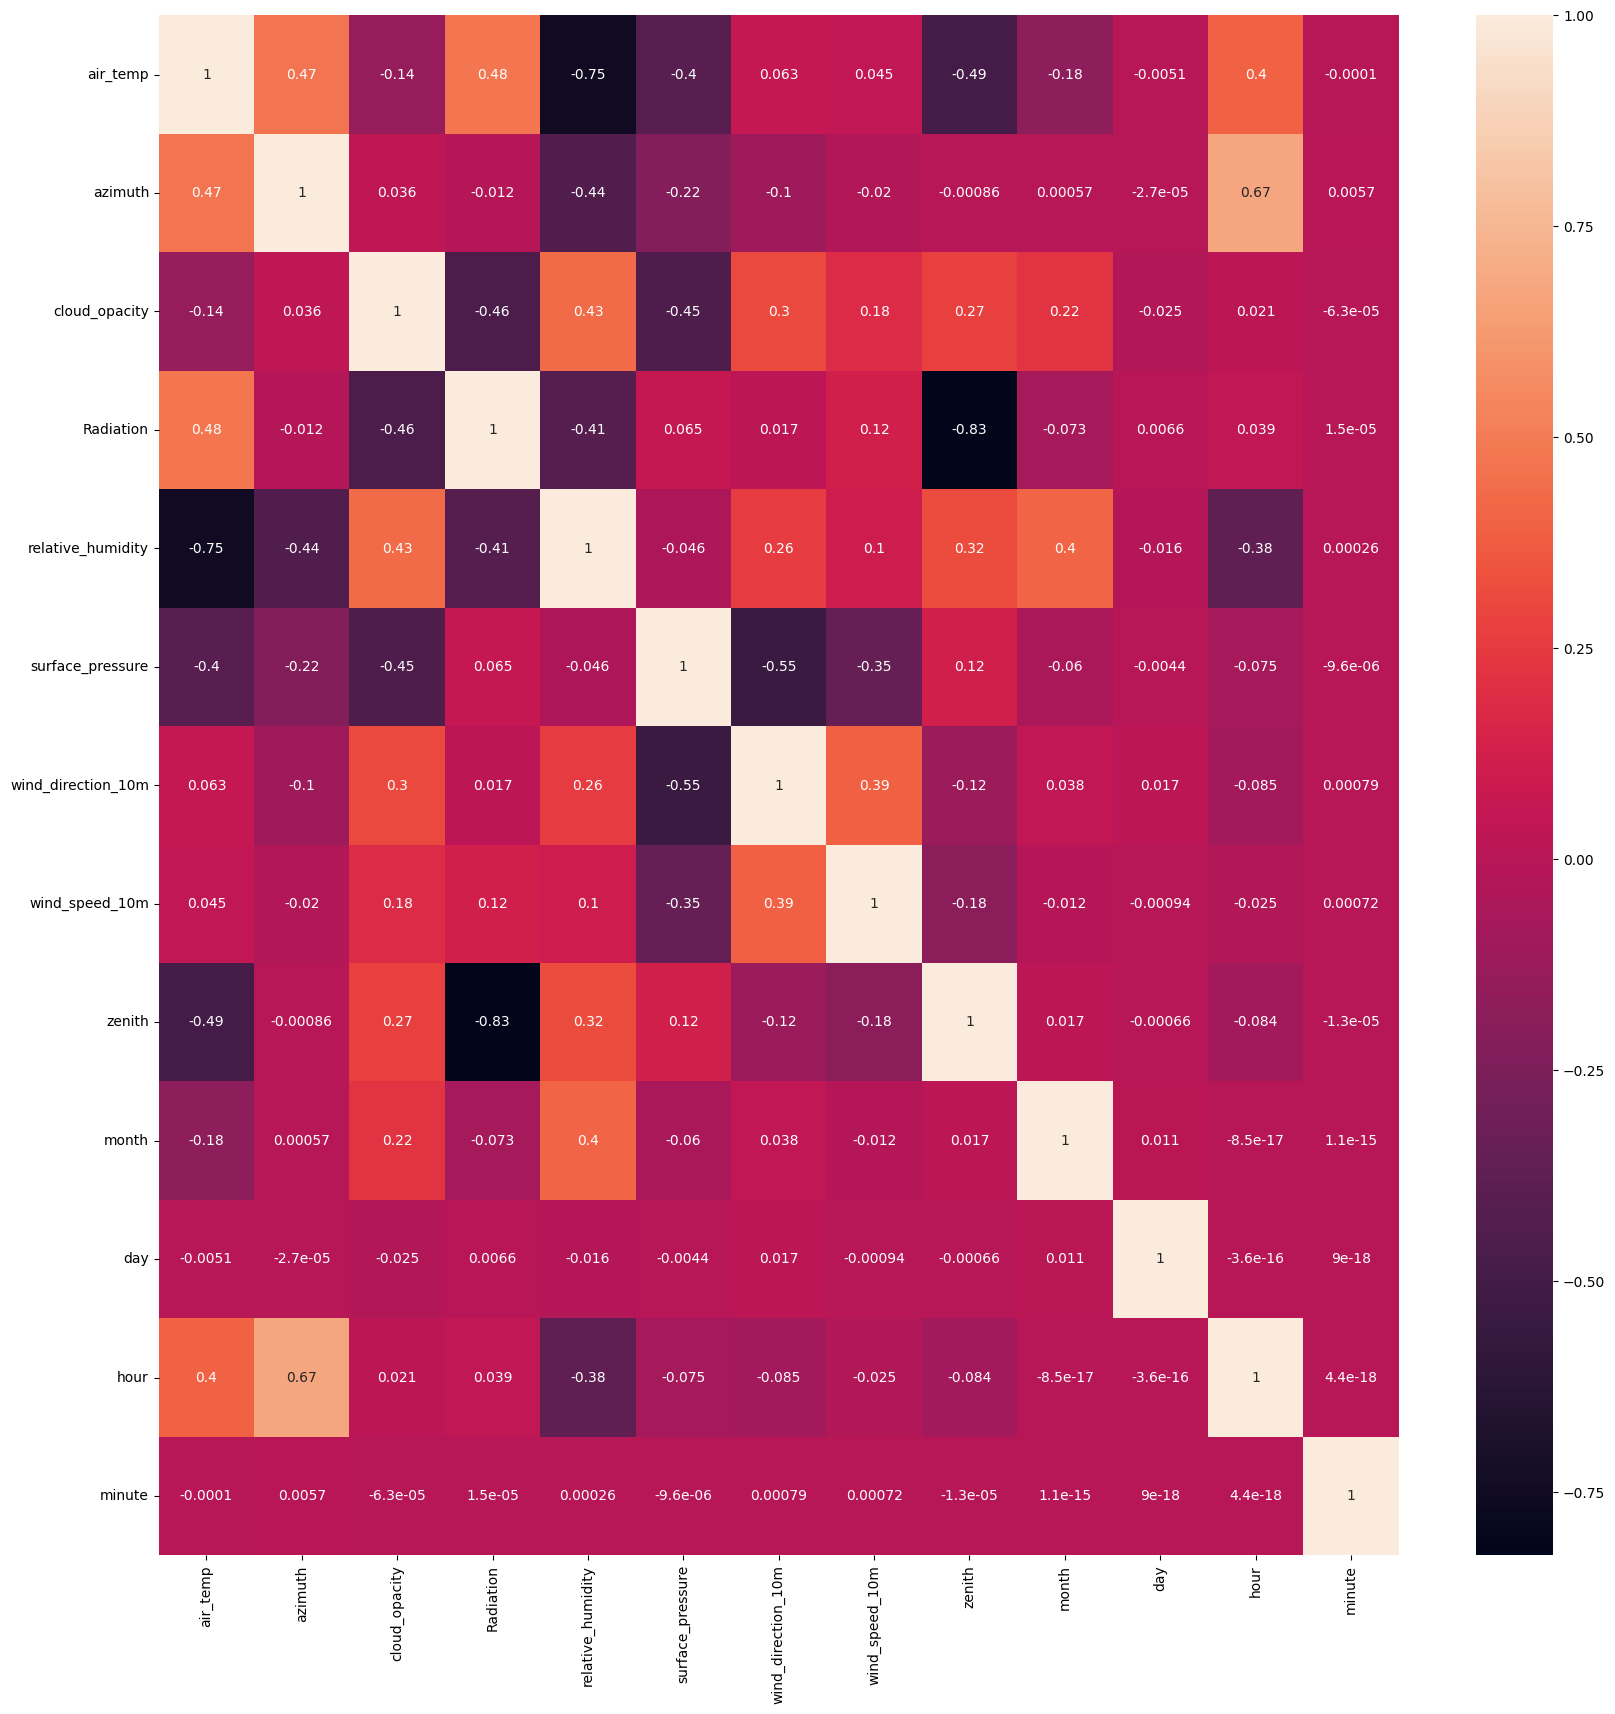

In [18]:
plt.figure(figsize=(20,20))
sns.heatmap(finaldata.corr(), annot=True)
plt.show()

**Feature Selection using SelectKBest Method**

In [19]:
bestfeatures = SelectKBest(score_func = chi2, k = 10)

In [20]:
# use the label encoder
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
train_Y = label_encoder.fit_transform(finaldata['Radiation'])

In [21]:
target_cont = finaldata['Radiation'].apply(lambda x : int(x*100))
scaled_input_features = MinMaxScaler().fit_transform(X)
fit = bestfeatures.fit(scaled_input_features, target_cont)

In [22]:
input_features = finaldata.drop('Radiation', axis = 1)
target = finaldata['Radiation']

In [23]:
scores = pd.DataFrame(fit.scores_)
column = pd.DataFrame(input_features.columns)

In [24]:
# contatinating data_features with the scores
featureScores = pd.concat([column, scores], axis=1)

#naming the dataframe columns
featureScores.columns = ['Features', 'feature_imp']

In [25]:
# best features
featureScores.sort_values(by = 'feature_imp', ascending=False, inplace=True)
featureScores

,Features,feature_imp
7,zenith,45930.936775
2,cloud_opacity,29551.687250
3,relative_humidity,6065.896736
0,air_temp,4858.910035
8,month,1681.342931
6,wind_speed_10m,1160.910994
4,surface_pressure,661.194949
5,wind_direction_10m,538.531332
11,minute,371.863045
1,azimuth,345.134955


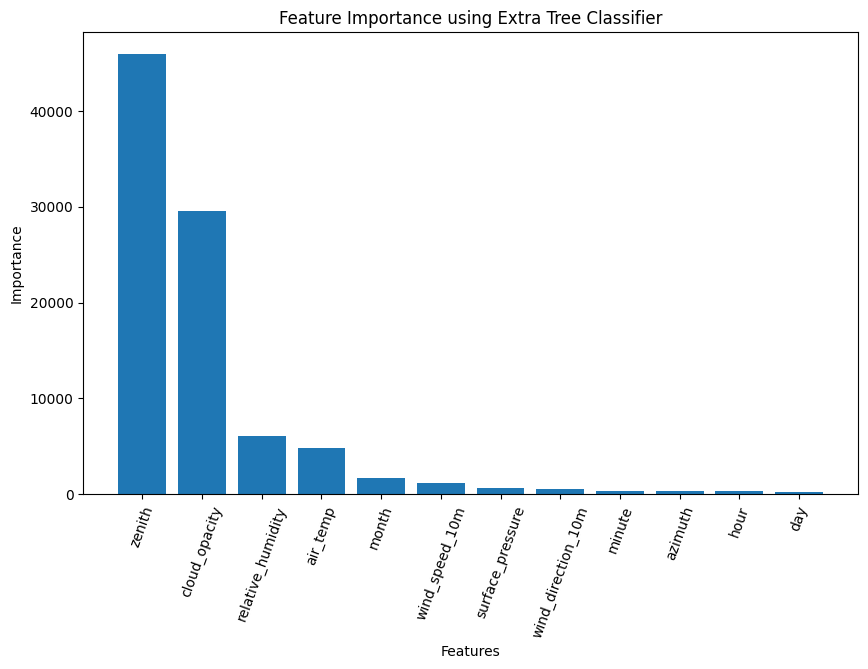

In [26]:
# visualise the feature importance
plt.figure(figsize = (10, 6))
plt.bar(featureScores.Features, featureScores.feature_imp)
plt.xticks(rotation = 70)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature Importance using Extra Tree Classifier")
plt.show()

**Preparing data - Standardisation and Splitting**

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=100)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.8, random_state=200)

In [28]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test, label=y_test)

Training

In [29]:
def get_model_rmse(params):
    model = xgb.train(params, dtrain, num_boost_round=100, evals=[(dval, 'eval')], early_stopping_rounds=10, verbose_eval=0)
    results = model.eval(dval)
    rmse = float(re.search(r'[\d.]+$', results).group(0))
    return rmse

In [30]:
def objective(trial):
    learning_rate = trial.suggest_loguniform('learning_rate', 0.00001, 10.0)
    max_depth = trial.suggest_int('max_depth', 4, 8)
    l1_reg = trial.suggest_loguniform('l1_reg', 0.00001, 10.0)
    l2_reg = trial.suggest_loguniform('l2_reg', 0.00001, 10.0)

    params = {'learning_rate': learning_rate, 'max_depth': max_depth, 'alpha': l1_reg, 'lambda': l2_reg}

    return get_model_rmse(params)

In [31]:
study = optuna.create_study()
study.optimize(objective, n_trials=100, show_progress_bar=True)

[I 2025-04-28 18:50:11,529] A new study created in memory with name: no-name-34471054-9cf7-4270-bf7c-048bd81940a1


  0%|          | 0/100 [00:00<?, ?it/s]

<ipython-input-30-0ed627bc5bda>:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.00001, 10.0)
<ipython-input-30-0ed627bc5bda>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l1_reg = trial.suggest_loguniform('l1_reg', 0.00001, 10.0)
<ipython-input-30-0ed627bc5bda>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_reg = trial.suggest_loguniform('l2_reg', 0.00001, 10.0)


[I 2025-04-28 18:50:22,214] Trial 0 finished with value: 293.2497755901185 and parameters: {'learning_rate': 2.4962228257493645e-05, 'max_depth': 6, 'l1_reg': 1.5208803946263743, 'l2_reg': 0.004298453034472092}. Best is trial 0 with value: 293.2497755901185.
[I 2025-04-28 18:50:26,664] Trial 1 finished with value: 30.28877999787057 and parameters: {'learning_rate': 0.024701779246610506, 'max_depth': 8, 'l1_reg': 0.040493198226359044, 'l2_reg': 0.008812797300934268}. Best is trial 1 with value: 30.28877999787057.
[I 2025-04-28 18:50:28,774] Trial 2 finished with value: 292.3149491751429 and parameters: {'learning_rate': 5.712081526599844e-05, 'max_depth': 7, 'l1_reg': 0.006956054901367756, 'l2_reg': 1.8683338313777262}. Best is trial 1 with value: 30.28877999787057.
[I 2025-04-28 18:50:30,358] Trial 3 finished with value: 287.5155973984962 and parameters: {'learning_rate': 0.0002256697962806543, 'max_depth': 5, 'l1_reg': 3.444623167239581e-05, 'l2_reg': 5.4711091255065175e-05}. Best is 

In [32]:
best_params = study.best_params
best_params

{'learning_rate': 0.39673593127380236,
 'max_depth': 8,
 'l1_reg': 0.2681137201061939,
 'l2_reg': 0.35545472091698177}

In [33]:
model = xgb.train(best_params, dtrain, num_boost_round=10000, evals=[(dval, 'eval')], early_stopping_rounds=10)

[0]	eval-rmse:178.41320
[1]	eval-rmse:109.04689
[2]	eval-rmse:67.70948
[3]	eval-rmse:43.68080
[4]	eval-rmse:30.33267
[5]	eval-rmse:23.32822
[6]	eval-rmse:19.88545


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:54:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "l1_reg", "l2_reg" } are not used.

  warnings.warn(smsg, UserWarning)


[7]	eval-rmse:18.03314
[8]	eval-rmse:17.30625
[9]	eval-rmse:16.77689
[10]	eval-rmse:16.24870
[11]	eval-rmse:15.98677
[12]	eval-rmse:15.67137
[13]	eval-rmse:15.28597
[14]	eval-rmse:15.01234
[15]	eval-rmse:14.83022
[16]	eval-rmse:14.66419
[17]	eval-rmse:14.34403
[18]	eval-rmse:14.23827
[19]	eval-rmse:14.03397
[20]	eval-rmse:13.85587
[21]	eval-rmse:13.60625
[22]	eval-rmse:13.48957
[23]	eval-rmse:13.24319
[24]	eval-rmse:13.03869
[25]	eval-rmse:12.97038
[26]	eval-rmse:12.93292
[27]	eval-rmse:12.83585
[28]	eval-rmse:12.69459
[29]	eval-rmse:12.61135
[30]	eval-rmse:12.48620
[31]	eval-rmse:12.36851
[32]	eval-rmse:12.29313
[33]	eval-rmse:12.17121
[34]	eval-rmse:12.08471
[35]	eval-rmse:11.99444
[36]	eval-rmse:11.96907
[37]	eval-rmse:11.87592
[38]	eval-rmse:11.79412
[39]	eval-rmse:11.70812
[40]	eval-rmse:11.67030
[41]	eval-rmse:11.63684
[42]	eval-rmse:11.60643
[43]	eval-rmse:11.53781
[44]	eval-rmse:11.42222
[45]	eval-rmse:11.34967
[46]	eval-rmse:11.29249
[47]	eval-rmse:11.23375
[48]	eval-rmse:11.1

In [34]:
y_true = np.array(y_test, dtype=float)
y_pred = np.array(model.predict(dtest), dtype=float)

In [35]:
r2 = r2_score(y_true, y_pred)

print("R^2 Score: {:.4f}".format(r2))

R^2 Score: 0.9996


In [36]:
scaler.feature_names_in_

array(['air_temp', 'azimuth', 'cloud_opacity', 'relative_humidity',
       'surface_pressure', 'wind_direction_10m', 'wind_speed_10m',
       'zenith', 'month', 'day', 'hour', 'minute'], dtype=object)

In [37]:
# prompt: save model

import joblib

# Assuming 'model' is your trained XGBoost model
joblib.dump(model, 'solar_radiation_model.pkl')

['solar_radiation_model.pkl']

In [38]:
# prompt: save standard scalar

import joblib
# Assuming 'scaler' is your StandardScaler object
joblib.dump(scaler, 'standard_scaler.pkl')

['standard_scaler.pkl']

In [39]:
# Save DataFrame to CSV
finaldata.to_csv('output1.csv', index=False)
